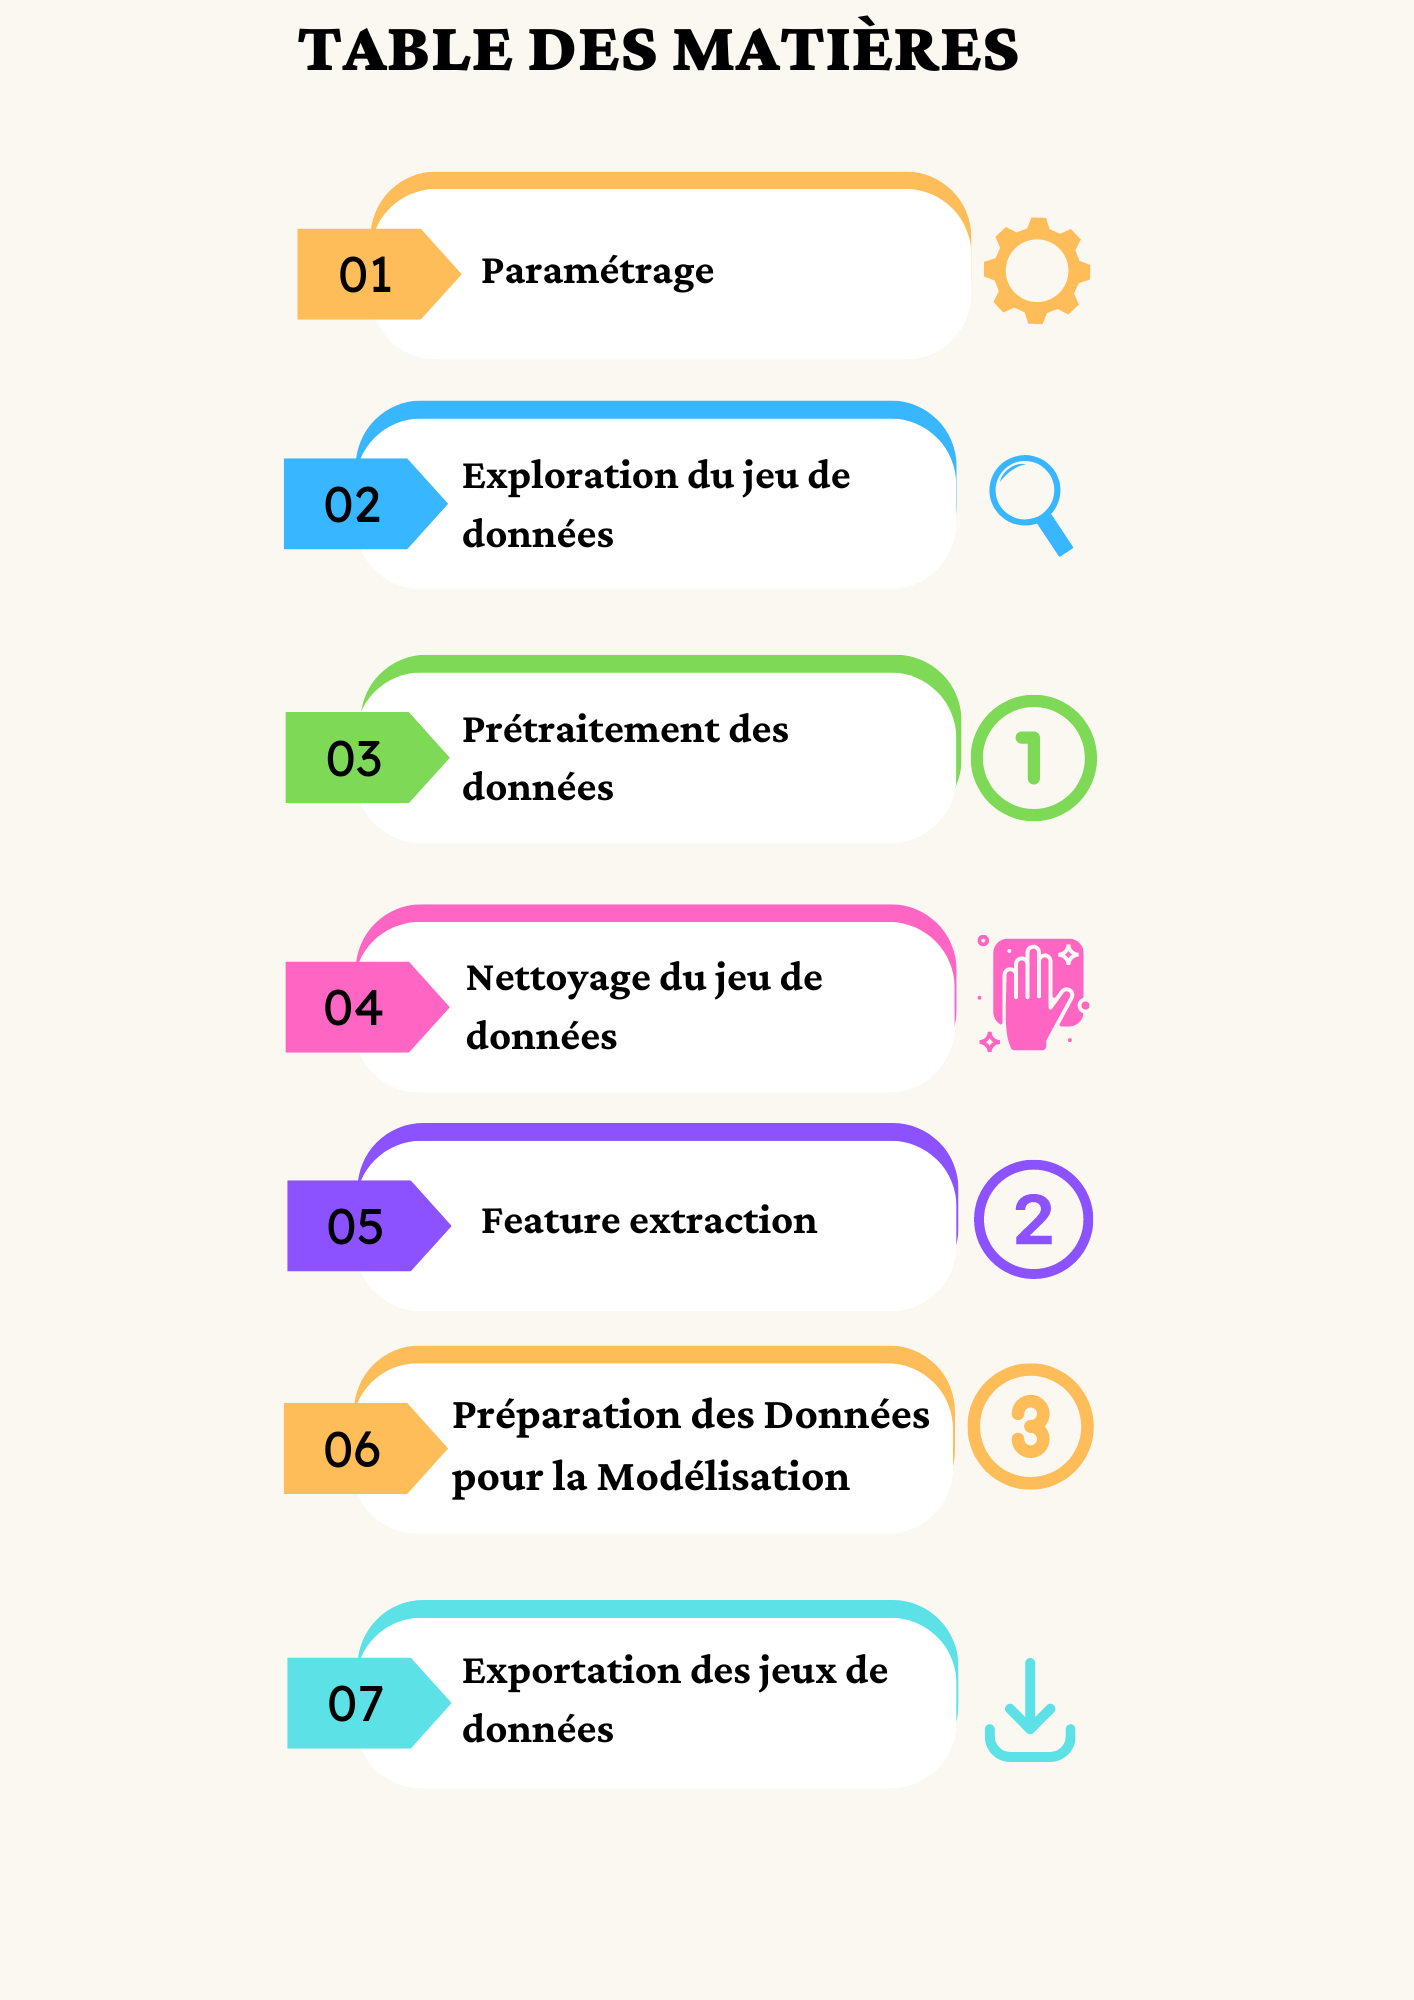

# Paramétrage

## Importation des librairies

In [1]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.probability import FreqDist
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from scipy.sparse import save_npz

from gensim.models import Word2Vec

from transformers import BertTokenizer, TFBertModel

import tensorflow as tf

from tqdm import tqdm

import os

from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to /home/kantan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/kantan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/kantan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/kantan/miniconda3/envs/tf_gpu/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-09-07 19:25:37.103921: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-09-07 19:25:40.330350: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-07 19:25:40.414683: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-07 19:25:40.419032: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
import tensorflow as tf

# Liste des GPUs disponibles
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Allouer progressivement la mémoire GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Limiter l'utilisation de la mémoire GPU (par exemple, à 90%)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10240)])  # 10GB de mémoire limite
    except RuntimeError as e:
        print(e)

## Importation du jeu de données

Lors de la lecture du fichier CSV, les colonnes n'étaient pas correctement nommées, entraînant une mauvaise interprétation des données. 

Pour résoudre ce problème, nous nous sommes référés à la documentation Kaggle du dataset **Sentiment140** disponible ici [Sentiment140 dataset with 1.6 million tweets](https://www.kaggle.com/datasets/kazanova/sentiment140) et avons spécifié explicitement les noms des colonnes lors de la lecture du fichier.

In [4]:
# Chemin absolu au fichier CSV
file_path = "../Data/training.1600000.processed.noemoticon.csv"

# Spécifiez l'encodage et les noms des colonnes
column_names = ['target', 'ids', 'date', 'flag', 'user', 'text']

# Charger le fichier CSV
data = pd.read_csv(file_path, encoding='ISO-8859-1', names=column_names)

# Exploration du jeu de données

## Affichage des cinq premières lignes de notre DataFrame

In [5]:
data.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## Liste des colonnes du DataFrame 

In [6]:
data.columns.tolist()

['target', 'ids', 'date', 'flag', 'user', 'text']

## Affichage les informations de notre DataFrame

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


## Affichage du nombre de lignes et de colonnes dans le Data Frame

In [8]:
print("Nombre de colonnes :", data.shape[1])
print("Nombre de lignes :", data.shape[0])

Nombre de colonnes : 6
Nombre de lignes : 1600000


## Affichage des types de données de chaque colonne

In [9]:
print("Types de données :")
data.dtypes

Types de données :


target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

# Prétraitement des données

## Tokenisation

In [10]:
def preprocess_text(text):
    tokens = word_tokenize(text, language='english')
    tokens = [token.lower() for token in tokens if token.isalpha()]
    return tokens

# Appliquer la fonction preprocess_text à chaque tweet
data['preprocessed_text'] = data['text'].apply(preprocess_text)

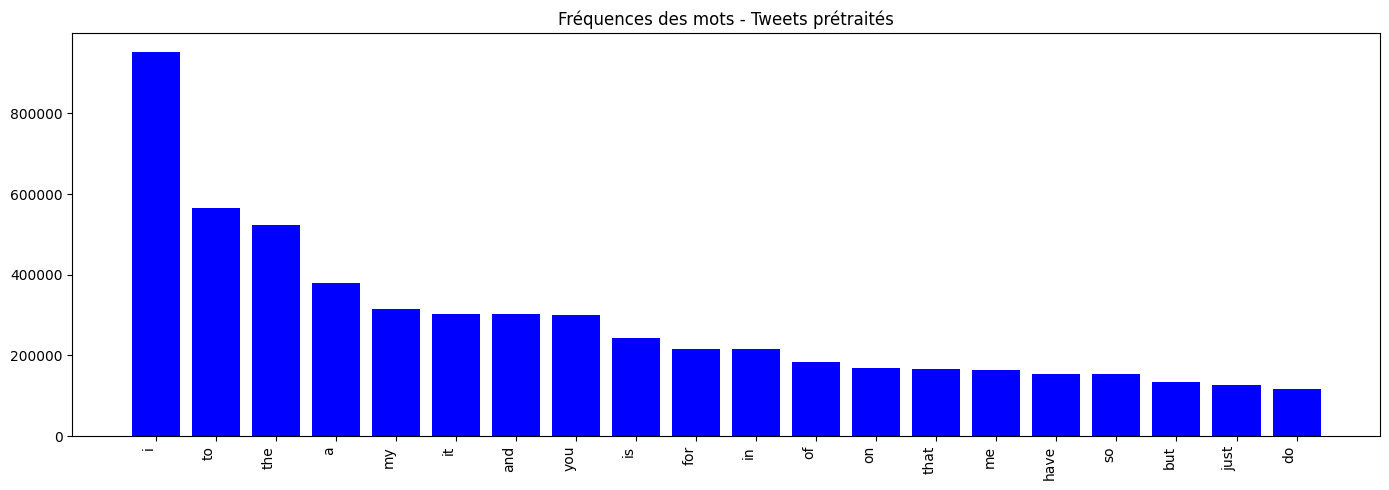

In [11]:
def plot_word_frequencies(text_tokens, title, ax):
    freq_dist = nltk.FreqDist(text_tokens)
    words = [word for word, freq in freq_dist.most_common(20)]
    frequencies = [freq for word, freq in freq_dist.most_common(20)]
    ax.bar(words, frequencies, color='b')
    ax.set_title(title)
    ax.set_xticks(range(len(words)))
    ax.set_xticklabels(words, rotation=90, ha="right")

# Combinez tous les tokens en une seule liste
all_tokens = [token for sublist in data['preprocessed_text'] for token in sublist]

# Créer la figure et les axes
fig, axs = plt.subplots(1, 1, figsize=(14, 5))
plot_word_frequencies(all_tokens, 'Fréquences des mots - Tweets prétraités', axs)
plt.tight_layout()
plt.show()

# Nettoyage du jeu de données

## Affichage du pourcentage de valeurs manquantes par colonne

In [12]:
(data.isnull().mean() * 100).astype(int)

target               0
ids                  0
date                 0
flag                 0
user                 0
text                 0
preprocessed_text    0
dtype: int64

## Detection des doublons

In [13]:
# Spécifiez les colonnes pertinentes pour la vérification des doublons
columns_to_check = ['target', 'ids', 'date', 'flag', 'user', 'text']

duplicates = data[data.duplicated(subset=columns_to_check)]

if len(duplicates) > 0:
    print("Notre jeu de données contient", len(duplicates), "doublon(s).")
else:
    print("Notre jeu de données ne contient pas de doublons.")

Notre jeu de données ne contient pas de doublons.


## Élimination des stopwords

### Via lemmatiseur

In [14]:
# Initialiser le lemmatiseur
lemmatizer = WordNetLemmatizer()

# Fonction pour lemmatiser les tokens en éliminant les stopwords
def lemmatize_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return lemmatized_tokens

# Application de la fonction de lemmatisation aux tweets pré-traités
data['lemmatized_text'] = data['preprocessed_text'].apply(lemmatize_tokens)

# Afficher les résultats pour vérification
print(data[['text', 'preprocessed_text', 'lemmatized_text']].head())

                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                   preprocessed_text  \
0  [switchfoot, http, awww, that, a, bummer, you,...   
1  [is, upset, that, he, ca, update, his, faceboo...   
2  [kenichan, i, dived, many, times, for, the, ba...   
3  [my, whole, body, feels, itchy, and, like, its...   
4  [nationwideclass, no, it, not, behaving, at, a...   

                                     lemmatized_text  
0  [switchfoot, http, awww, bummer, shoulda, got,...  
1  [upset, ca, update, facebook, texting, might, ...  
2  [kenichan, dived, many, time, ball, managed, s...  
3             [whole, body, feel, itchy, like, fire]  
4          [nationwideclass, behaving, mad, ca, see

### Via Stemmer

In [15]:
# Initialiser le stemmer
stemmer = PorterStemmer()

# Fonction pour appliquer le stemming aux tokens
def stem_tokens(tokens):
    stop_words = set(stopwords.words('english'))
    stemmed_tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return stemmed_tokens

# Application de la fonction de stemming aux tweets pré-traités
data['stemmed_text'] = data['preprocessed_text'].apply(stem_tokens)

# Afficher les résultats pour vérification
print(data[['text', 'preprocessed_text', 'stemmed_text']].head())

                                                text  \
0  @switchfoot http://twitpic.com/2y1zl - Awww, t...   
1  is upset that he can't update his Facebook by ...   
2  @Kenichan I dived many times for the ball. Man...   
3    my whole body feels itchy and like its on fire    
4  @nationwideclass no, it's not behaving at all....   

                                   preprocessed_text  \
0  [switchfoot, http, awww, that, a, bummer, you,...   
1  [is, upset, that, he, ca, update, his, faceboo...   
2  [kenichan, i, dived, many, times, for, the, ba...   
3  [my, whole, body, feels, itchy, and, like, its...   
4  [nationwideclass, no, it, not, behaving, at, a...   

                                        stemmed_text  
0  [switchfoot, http, awww, bummer, shoulda, got,...  
1  [upset, ca, updat, facebook, text, might, cri,...  
2  [kenichan, dive, mani, time, ball, manag, save...  
3             [whole, bodi, feel, itchi, like, fire]  
4             [nationwideclass, behav, mad, ca, see

### Comparaison des fréquences en fonction des méthodes de nettoyage

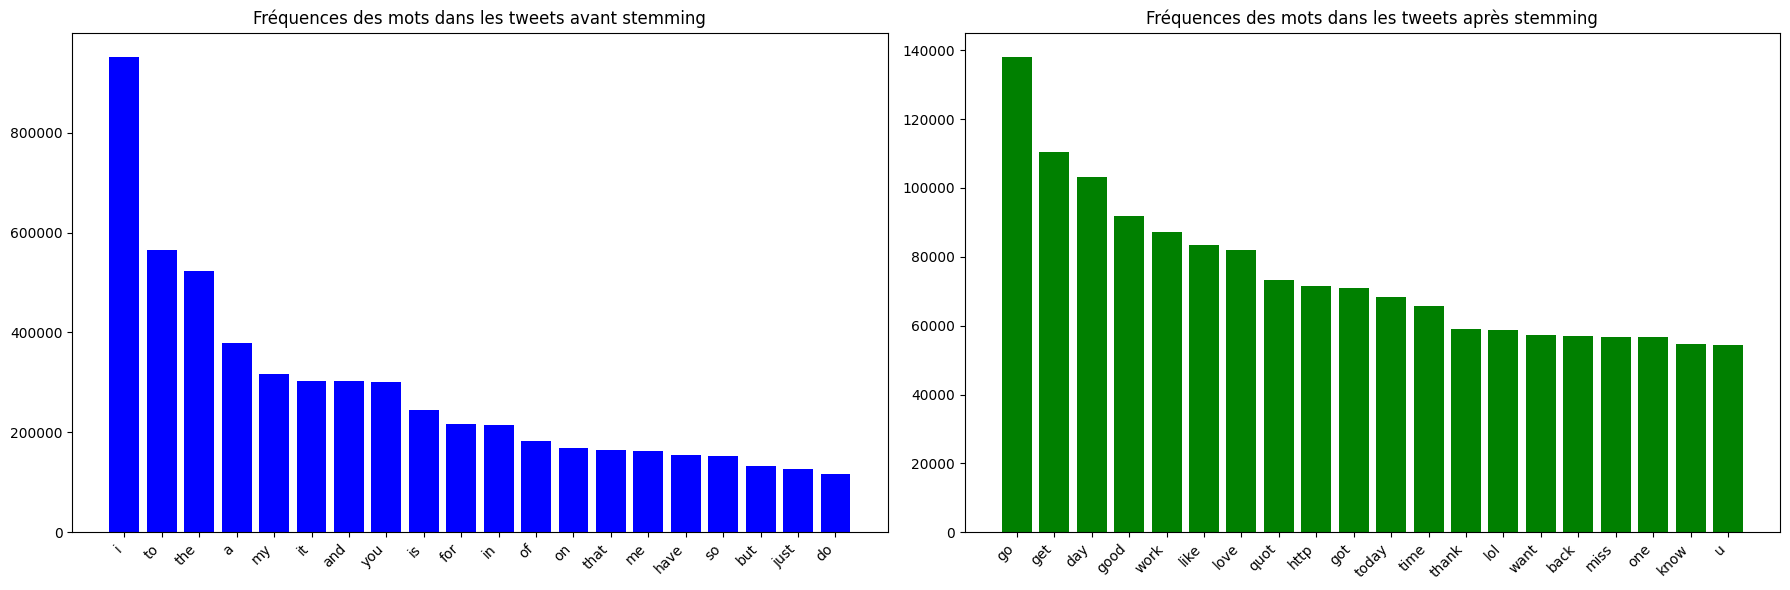

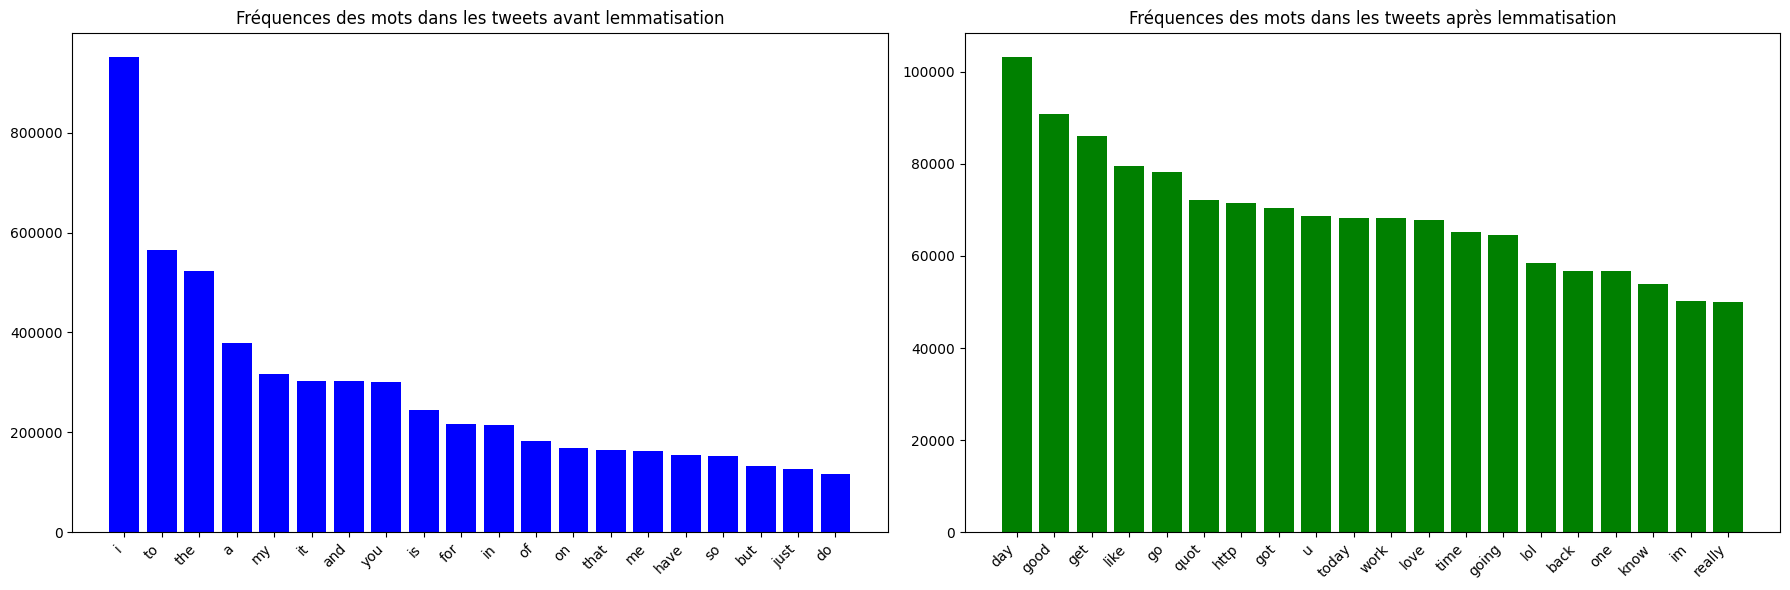

In [16]:
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.probability import FreqDist

# Fonction pour comparer les fréquences des mots avant et après une transformation
def plot_word_frequencies_compare(counter_before, counter_after, title_before, title_after):
    words_before, frequencies_before = zip(*counter_before.most_common(20))
    words_after, frequencies_after = zip(*counter_after.most_common(20))
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    ax1.bar(words_before, frequencies_before, color='blue')
    ax1.set_title(title_before)
    ax1.set_xticks(range(len(words_before)))
    ax1.set_xticklabels(words_before, rotation=45, ha="right")
    
    ax2.bar(words_after, frequencies_after, color='green')
    ax2.set_title(title_after)
    ax2.set_xticks(range(len(words_after)))
    ax2.set_xticklabels(words_after, rotation=45, ha="right")
    
    plt.tight_layout()
    plt.show()

# Calculer les fréquences des mots avant et après stemming
counter_before_stemming = Counter([word for tokens in data['preprocessed_text'] for word in tokens])
counter_after_stemming = Counter([word for tokens in data['stemmed_text'] for word in tokens])

# Calculer les fréquences des mots avant et après lemmatisation
counter_before_lemmatization = Counter([word for tokens in data['preprocessed_text'] for word in tokens])
counter_after_lemmatization = Counter([word for tokens in data['lemmatized_text'] for word in tokens])

# Utilisation de la fonction pour comparer les fréquences avant et après stemming
plot_word_frequencies_compare(counter_before_stemming, counter_after_stemming,
                              "Fréquences des mots dans les tweets avant stemming", 
                              "Fréquences des mots dans les tweets après stemming")

# Utilisation de la fonction pour comparer les fréquences avant et après lemmatisation
plot_word_frequencies_compare(counter_before_lemmatization, counter_after_lemmatization,
                              "Fréquences des mots dans les tweets avant lemmatisation", 
                              "Fréquences des mots dans les tweets après lemmatisation")

# Feature extraction

In [17]:
data.columns.tolist()

['target',
 'ids',
 'date',
 'flag',
 'user',
 'text',
 'preprocessed_text',
 'lemmatized_text',
 'stemmed_text']

## Représentation vectorielle du texte

### Bag of Words (BoW)

In [18]:
# Convertir les listes en chaînes de caractères
data['lemmatized_text_str'] = data['lemmatized_text'].apply(lambda x: ' '.join(x))
data['stemmed_text_str'] = data['stemmed_text'].apply(lambda x: ' '.join(x))

# Initialisation de CountVectorizer pour chaque traitement
bow_vectorizer_lemmatized = CountVectorizer()
bow_vectorizer_stemmed = CountVectorizer()

# Application du CountVectorizer pour les différentes colonnes
bow_features_lemmatized = bow_vectorizer_lemmatized.fit_transform(data['lemmatized_text_str'])
bow_features_stemmed = bow_vectorizer_stemmed.fit_transform(data['stemmed_text_str'])

# Utiliser les matrices sparse pour éviter l'erreur de mémoire
df_bow_lemmatized = pd.DataFrame.sparse.from_spmatrix(bow_features_lemmatized, columns=bow_vectorizer_lemmatized.get_feature_names_out()).add_prefix('lem_bow_')
df_bow_stemmed = pd.DataFrame.sparse.from_spmatrix(bow_features_stemmed, columns=bow_vectorizer_stemmed.get_feature_names_out()).add_prefix('stem_bow_')

# Ajouter les colonnes 'id' et 'target' aux DataFrames de résultats
df_bow_lemmatized['id'] = data['ids']
df_bow_lemmatized['target'] = data['target']
df_bow_stemmed['id'] = data['ids']
df_bow_stemmed['target'] = data['target']

df_bow_lemmatized.head()

,lem_bow_aa,lem_bow_aaa,lem_bow_aaaa,lem_bow_aaaaa,lem_bow_aaaaaa,lem_bow_aaaaaaa,lem_bow_aaaaaaaa,lem_bow_aaaaaaaaa,lem_bow_aaaaaaaaaa,lem_bow_aaaaaaaaaaa,...,lem_bow_ðº,lem_bow_ðºð,lem_bow_ðºðµ,lem_bow_ðºñ,lem_bow_øª,lem_bow_øªù,lem_bow_øµù,lem_bow_øºøµ,id,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467810369,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467810672,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467810917,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467811184,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467811193,0


In [19]:
df_bow_stemmed.head()

,stem_bow_aa,stem_bow_aaa,stem_bow_aaaa,stem_bow_aaaaa,stem_bow_aaaaaa,stem_bow_aaaaaaa,stem_bow_aaaaaaaa,stem_bow_aaaaaaaaa,stem_bow_aaaaaaaaaa,stem_bow_aaaaaaaaaaa,...,stem_bow_ðº,stem_bow_ðºð,stem_bow_ðºðµ,stem_bow_ðºñ,stem_bow_øª,stem_bow_øªù,stem_bow_øµù,stem_bow_øºøµ,id,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467810369,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467810672,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467810917,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467811184,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1467811193,0


### TF-IDF

In [20]:
# Initialisation de TfidfVectorizer pour chaque traitement
tfidf_vectorizer_lemmatized = TfidfVectorizer()
tfidf_vectorizer_stemmed = TfidfVectorizer()

# Application du TfidfVectorizer pour les différentes colonnes
tfidf_features_lemmatized = tfidf_vectorizer_lemmatized.fit_transform(data['lemmatized_text_str'])
tfidf_features_stemmed = tfidf_vectorizer_stemmed.fit_transform(data['stemmed_text_str'])

# Utiliser les matrices sparse pour éviter l'erreur de mémoire
df_tfidf_lemmatized = pd.DataFrame.sparse.from_spmatrix(tfidf_features_lemmatized, columns=tfidf_vectorizer_lemmatized.get_feature_names_out()).add_prefix('lem_tfidf_')
df_tfidf_stemmed = pd.DataFrame.sparse.from_spmatrix(tfidf_features_stemmed, columns=tfidf_vectorizer_stemmed.get_feature_names_out()).add_prefix('stem_tfidf_')

# Ajouter les colonnes 'id' et 'target' aux DataFrames de résultats
df_tfidf_lemmatized['id'] = data['ids']
df_tfidf_lemmatized['target'] = data['target']
df_tfidf_stemmed['id'] = data['ids']
df_tfidf_stemmed['target'] = data['target']

df_tfidf_lemmatized.head()

,lem_tfidf_aa,lem_tfidf_aaa,lem_tfidf_aaaa,lem_tfidf_aaaaa,lem_tfidf_aaaaaa,lem_tfidf_aaaaaaa,lem_tfidf_aaaaaaaa,lem_tfidf_aaaaaaaaa,lem_tfidf_aaaaaaaaaa,lem_tfidf_aaaaaaaaaaa,...,lem_tfidf_ðº,lem_tfidf_ðºð,lem_tfidf_ðºðµ,lem_tfidf_ðºñ,lem_tfidf_øª,lem_tfidf_øªù,lem_tfidf_øµù,lem_tfidf_øºøµ,id,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467810369,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467810672,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467810917,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467811184,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467811193,0


In [21]:
df_tfidf_stemmed.head()

,stem_tfidf_aa,stem_tfidf_aaa,stem_tfidf_aaaa,stem_tfidf_aaaaa,stem_tfidf_aaaaaa,stem_tfidf_aaaaaaa,stem_tfidf_aaaaaaaa,stem_tfidf_aaaaaaaaa,stem_tfidf_aaaaaaaaaa,stem_tfidf_aaaaaaaaaaa,...,stem_tfidf_ðº,stem_tfidf_ðºð,stem_tfidf_ðºðµ,stem_tfidf_ðºñ,stem_tfidf_øª,stem_tfidf_øªù,stem_tfidf_øµù,stem_tfidf_øºøµ,id,target
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467810369,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467810672,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467810917,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467811184,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1467811193,0


## Word Embeddings

In [22]:
# Formation du modèle Word2Vec sur les textes lemmatisés
word2vec_model_lemmatized = Word2Vec(sentences=data['lemmatized_text'], vector_size=100, window=5, min_count=1, workers=4)

# Formation du modèle Word2Vec sur les textes stemmés
word2vec_model_stemmed = Word2Vec(sentences=data['stemmed_text'], vector_size=100, window=5, min_count=1, workers=4)

# Fonction pour calculer les embeddings moyens
def calculate_mean_embedding(tokens, model):
    if tokens:  # S'assure qu'il y a des tokens
        embeddings = [model.wv[token] for token in tokens if token in model.wv]
        return np.mean(embeddings, axis=0) if embeddings else np.zeros(100)
    else:
        return np.zeros(100)

# Calcul des embeddings moyens pour chaque texte lemmatisé
data['word2vec_features_lemmatized'] = data['lemmatized_text'].apply(lambda x: calculate_mean_embedding(x, word2vec_model_lemmatized).tolist())

# Calcul des embeddings moyens pour chaque texte stemmé
data['word2vec_features_stemmed'] = data['stemmed_text'].apply(lambda x: calculate_mean_embedding(x, word2vec_model_stemmed).tolist())

# Vérification des résultats
data[['ids', 'word2vec_features_lemmatized', 'word2vec_features_stemmed']].head()

,ids,word2vec_features_lemmatized,word2vec_features_stemmed
0,1467810369,"[-0.29403138160705566, 0.07041528075933456, 0....","[-0.3471446633338928, 0.17681023478507996, -0...."
1,1467810672,"[-0.14312271773815155, -0.3540247976779938, 0....","[-0.46136534214019775, 0.5716197490692139, 0.2..."
2,1467810917,"[-0.06894536316394806, 0.1997627317905426, 0.4...","[-1.3002161979675293, 0.36073583364486694, 0.1..."
3,1467811184,"[-0.3914307653903961, 0.1229797825217247, 1.19...","[-1.45766019821167, 0.6940624117851257, 1.1405..."
4,1467811193,"[-0.04380697011947632, -0.4118480086326599, 0....","[0.1093902438879013, 0.04960664361715317, -0.6..."


## Fine-Tuning des Modèles Pré-entraînés

In [23]:
from transformers import BertTokenizer, TFBertModel
import pandas as pd
import tensorflow as tf
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Initialiser le tokenizer et le modèle BERT avec TensorFlow
bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
bert_model = TFBertModel.from_pretrained(bert_model_name)

# Vérifier si TensorFlow utilise le GPU
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

def get_bert_embeddings(texts, batch_size=16):
    batched_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size), desc="Processing BERT Embeddings"):
        batch_texts = texts[i:i+batch_size]
        encoded_inputs = bert_tokenizer(batch_texts, return_tensors='tf', padding=True, truncation=True, max_length=512)
        outputs = bert_model(encoded_inputs)
        embeddings = outputs.pooler_output  # Utiliser pooler_output pour les embeddings des phrases
        batched_embeddings.extend(embeddings.numpy())
    return batched_embeddings

# Réaliser un échantillonnage aléatoire stratifié pour obtenir un sous-échantillon équilibré
data_small, _ = train_test_split(data, train_size=10000, stratify=data['target'], random_state=42)

# Convertir les textes lemmatisés et stemmés en listes de chaînes pour le traitement
lemmatized_texts = data_small['lemmatized_text_str'].tolist()
stemmed_texts = data_small['stemmed_text_str'].tolist()

# Obtenir les embeddings BERT pour chaque ensemble
try:
    bert_embeddings_lemmatized = get_bert_embeddings(lemmatized_texts)
    bert_embeddings_stemmed = get_bert_embeddings(stemmed_texts)
except MemoryError as e:
    print("MemoryError: ", e)
    bert_embeddings_lemmatized = []
    bert_embeddings_stemmed = []

# Stocker les embeddings dans le DataFrame
if bert_embeddings_lemmatized:
    data_small['bert_features_lemmatized'] = list(bert_embeddings_lemmatized)
if bert_embeddings_stemmed:
    data_small['bert_features_stemmed'] = list(bert_embeddings_stemmed)

2024-09-07 19:42:36.223914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-07 19:42:36.225189: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-07 19:42:36.232079: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-09-07 19:42:36.238280: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so retur

GPU found


Processing BERT Embeddings: 100%|█████████████████████████████████████████| 625/625 [01:01<00:00, 10.15it/s]


In [24]:
# Vérification des résultats pour un échantillon
data_small[['ids', 'bert_features_lemmatized', 'bert_features_stemmed']].head()

,ids,bert_features_lemmatized,bert_features_stemmed
500415,2186835492,"[-0.89794075, -0.2902676, -0.7251637, 0.871100...","[-0.8860485, -0.34733438, -0.7274647, 0.859917..."
1577236,2189647623,"[-0.6144975, -0.1400793, 0.6592635, 0.27299148...","[-0.5368745, -0.116302274, 0.7387565, 0.225198..."
178111,1965889776,"[-0.8517221, -0.4499652, -0.61011547, 0.791087...","[-0.8517221, -0.4499652, -0.61011547, 0.791087..."
396033,2056256086,"[-0.9158708, -0.43506968, -0.5389139, 0.820428...","[-0.76823926, -0.28316572, -0.011257935, 0.640..."
31962,1564138266,"[-0.7569984, -0.28674588, -0.18629198, 0.60591...","[-0.7247681, -0.27825618, -0.05598936, 0.56406..."


# Préparation des Données pour la Modélisation

## Gestion des déséquilibres de classe

In [25]:
data["target"].unique()

array([0, 4])

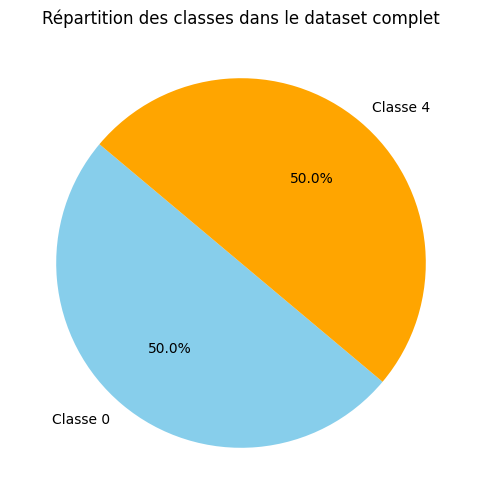

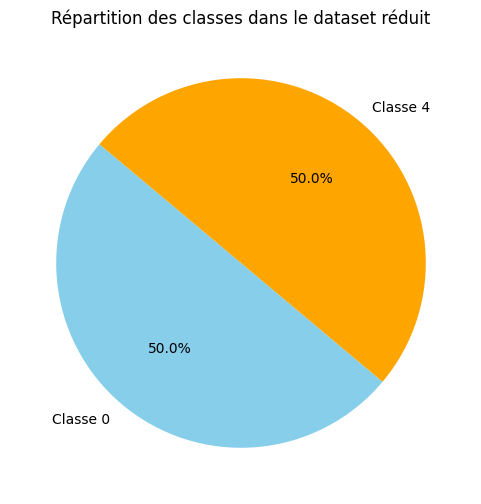

In [26]:
import matplotlib.pyplot as plt
from collections import Counter

# Fonction pour afficher le diagramme en camembert
def plot_pie_chart(y, title):
    counter = Counter(y)
    labels, sizes = zip(*counter.items())
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=[f'Classe {label}' for label in labels], autopct='%1.1f%%', startangle=140, colors=['skyblue', 'orange', 'green'])
    plt.title(title)
    plt.show()

# Afficher la répartition des classes dans le dataset complet
plot_pie_chart(data['target'], "Répartition des classes dans le dataset complet")

# Afficher la répartition des classes dans le dataset réduit (data_small) si pertinent
plot_pie_chart(data_small['target'], "Répartition des classes dans le dataset réduit")

# Modélisation

## Préprocessing

In [29]:
data.columns.tolist()

['target',
 'ids',
 'date',
 'flag',
 'user',
 'text',
 'preprocessed_text',
 'lemmatized_text',
 'stemmed_text',
 'lemmatized_text_str',
 'stemmed_text_str',
 'word2vec_features_lemmatized',
 'word2vec_features_stemmed']

In [30]:
data_small.columns.tolist()

['target',
 'ids',
 'date',
 'flag',
 'user',
 'text',
 'preprocessed_text',
 'lemmatized_text',
 'stemmed_text',
 'lemmatized_text_str',
 'stemmed_text_str',
 'word2vec_features_lemmatized',
 'word2vec_features_stemmed',
 'bert_features_lemmatized',
 'bert_features_stemmed']